---
layout: post
title:  "PCA: A pythonic explanation of Principle Component Analysis"
short_title: "Principle Component Analaysis Explained"
desc: "What is PCA? How does it work? Is the math that bad? How do I use it? All answers lie within!"
date: ###DATE
categories: [tutorial]
tags: [statistics]
loc: ###LOC
permalink: ###LINK 
redirect_from: "/pca"

math: true
---

In this small write up, we'll cover Principal Component Analysis from its mathematical routes, visual explanations and how to effectively utilise PCA using the sklearn library. We'll show PCA works by doing it manually in python without losing ourself in the mathematics!

# What is PCA?

PCA is a way of taking a dataset (a collection of points in some parameter/feature space) and determining what are the "principal components". These principal components represent vectors that encapsulate the information in your dataset. By taking only a few of the most significant components, we can compress our dataset down into a lower dimensional space without throwing out critical information.

## A visual example

Let's generate simple 2D data to begin with:

In [156]:
# Remove
from base import *
import numpy as np
np.random.seed(1)
plt.rcParams['lines.markersize'] = 2
plt.rcParams['axes.prop_cycle'] = (
    cycler(color=['#4CAF50', '#03A9F4', '#F77F00', '#FCBF49', '#EAE2B7']) + 
    cycler(linestyle=['-', '--', ':', '-.', '-']))

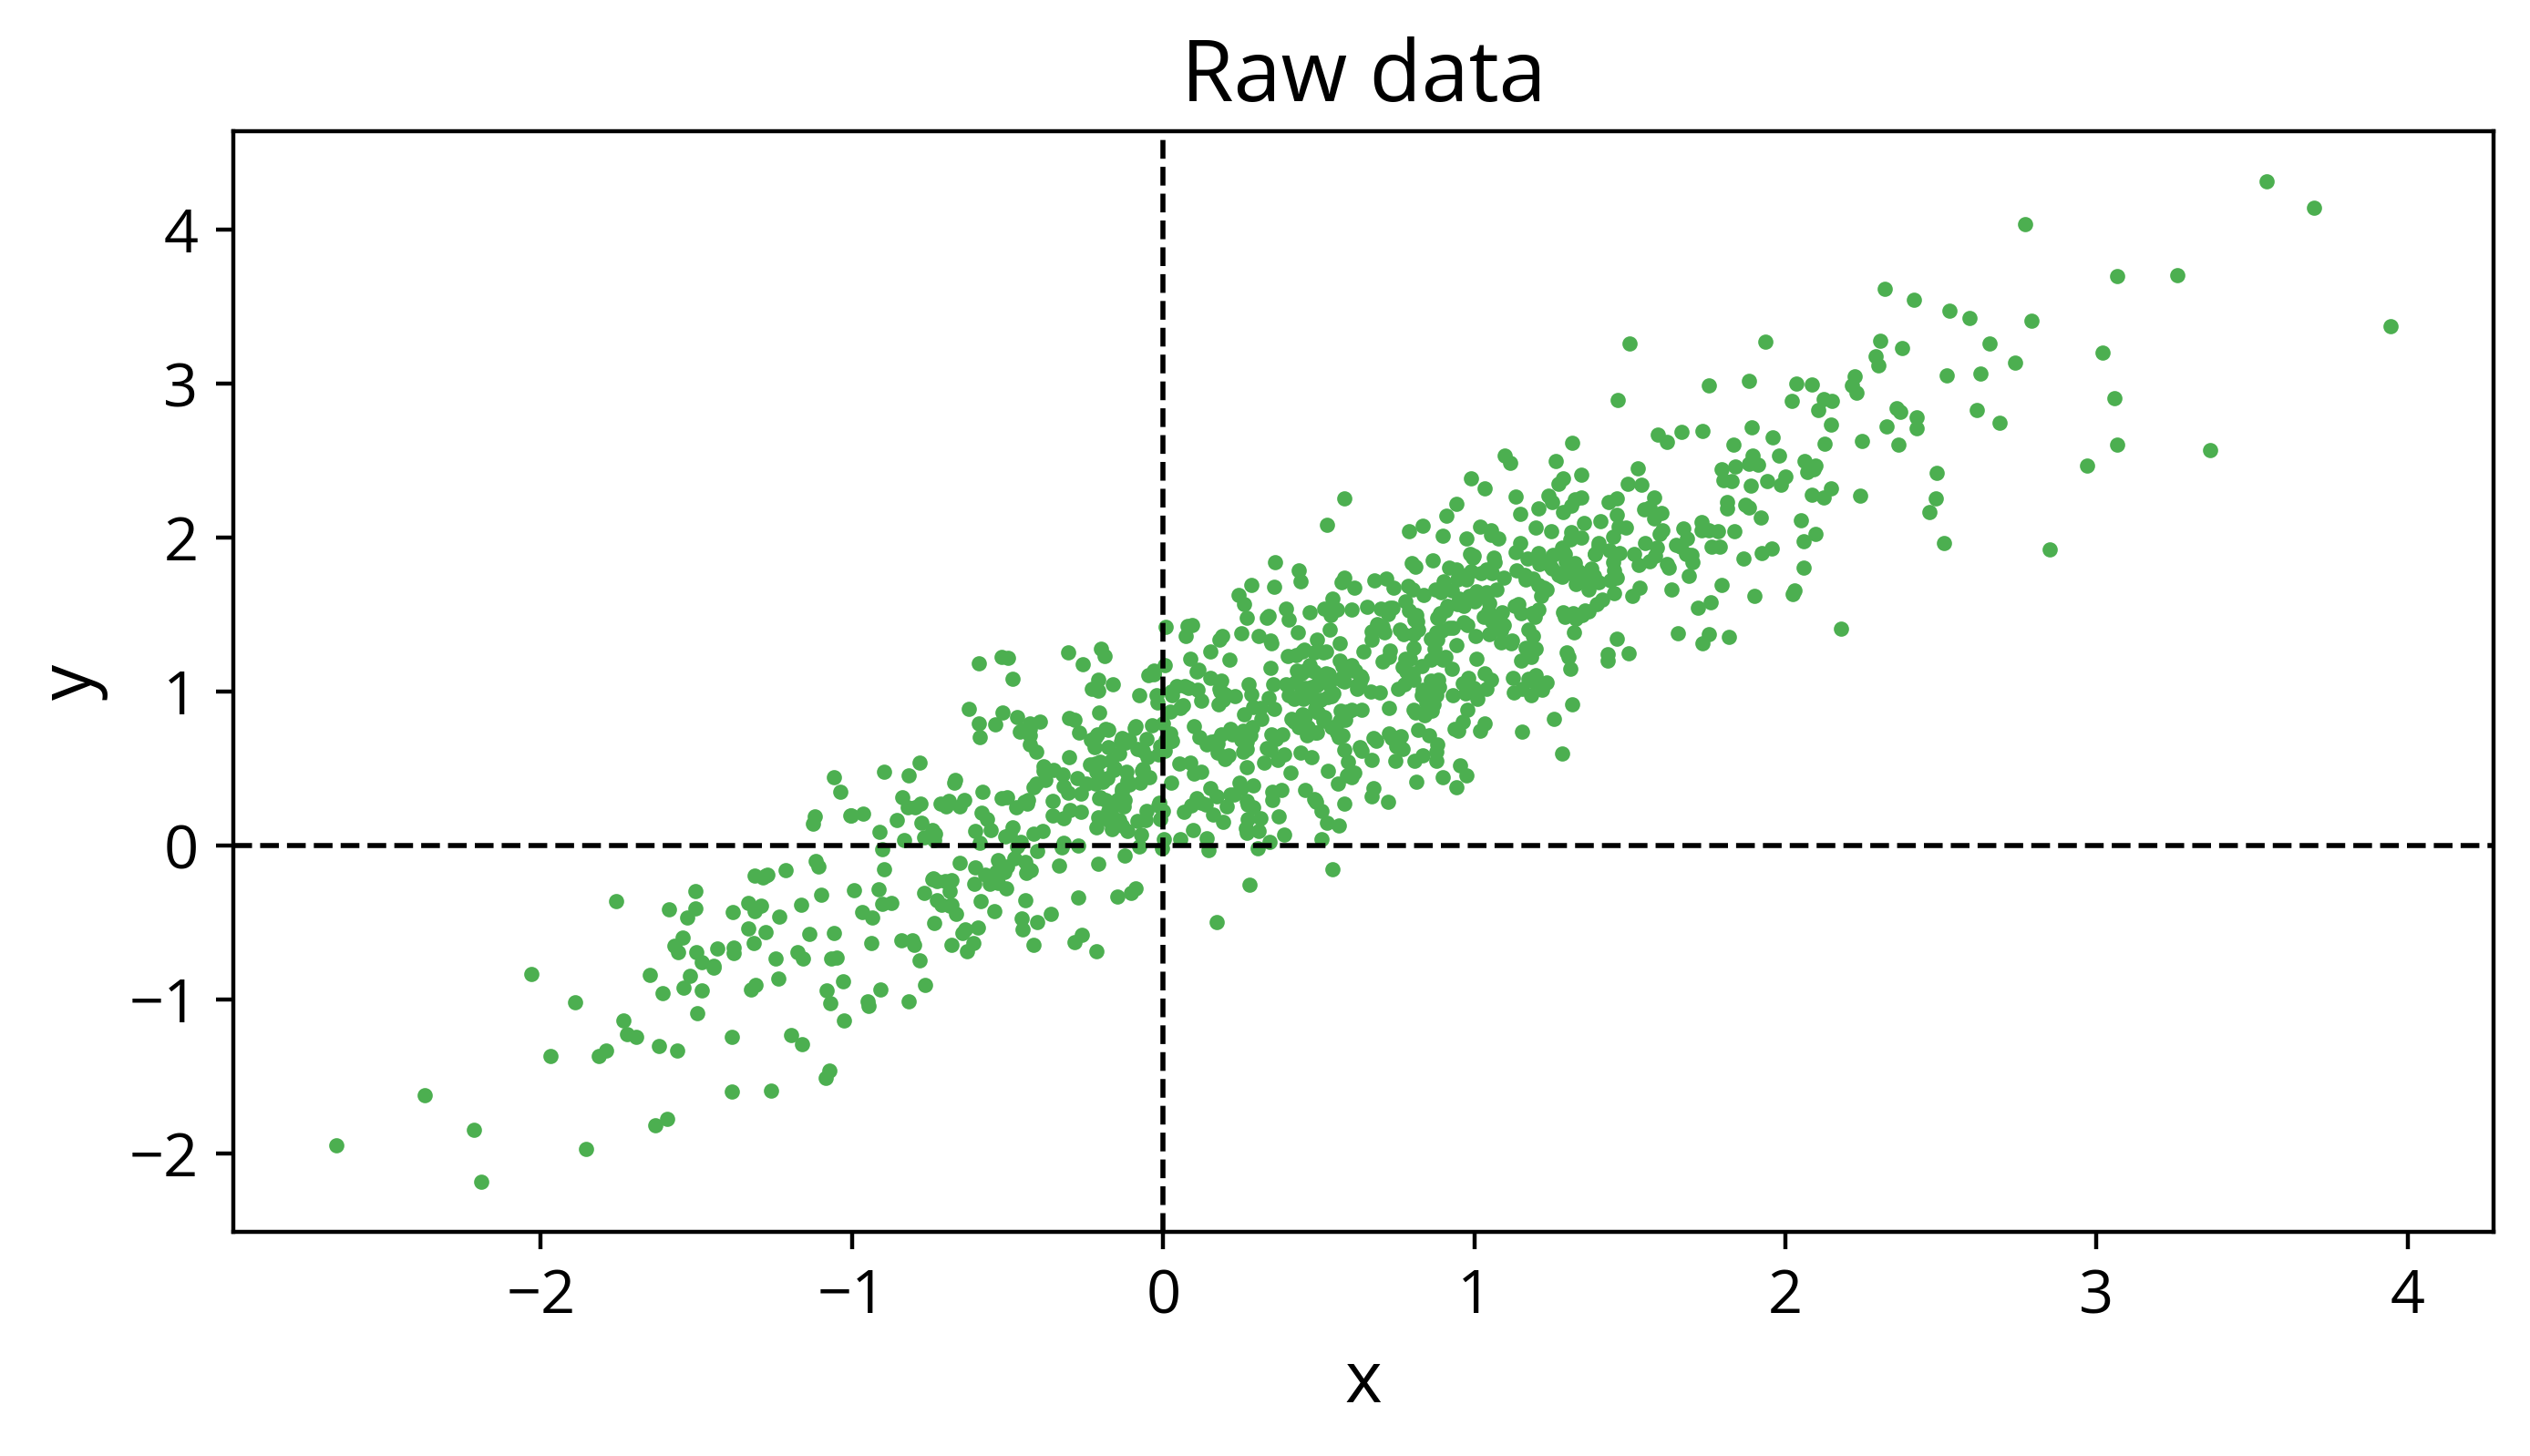

In [176]:
import numpy as np
import matplotlib.pyplot as plt

data = np.random.multivariate_normal([0.5, 1], [[1, 0.9],[0.9, 1]], size=1000)
                                              
plt.scatter(data[:, 0], data[:, 1])
plt.axvline(0, c="k", lw=1, ls="--"), plt.axhline(0, c="k", lw=1, ls="--")
plt.xlabel("x"), plt.ylabel("y"), plt.title("Raw data");

We have two dimensions of data, which are highly correlated. What if we wanted to remove this correlation? What if we wanted to get a single variable that encapsulates the information on where a data point lies along the bottom-left to top-right axis that we can so clearly see?

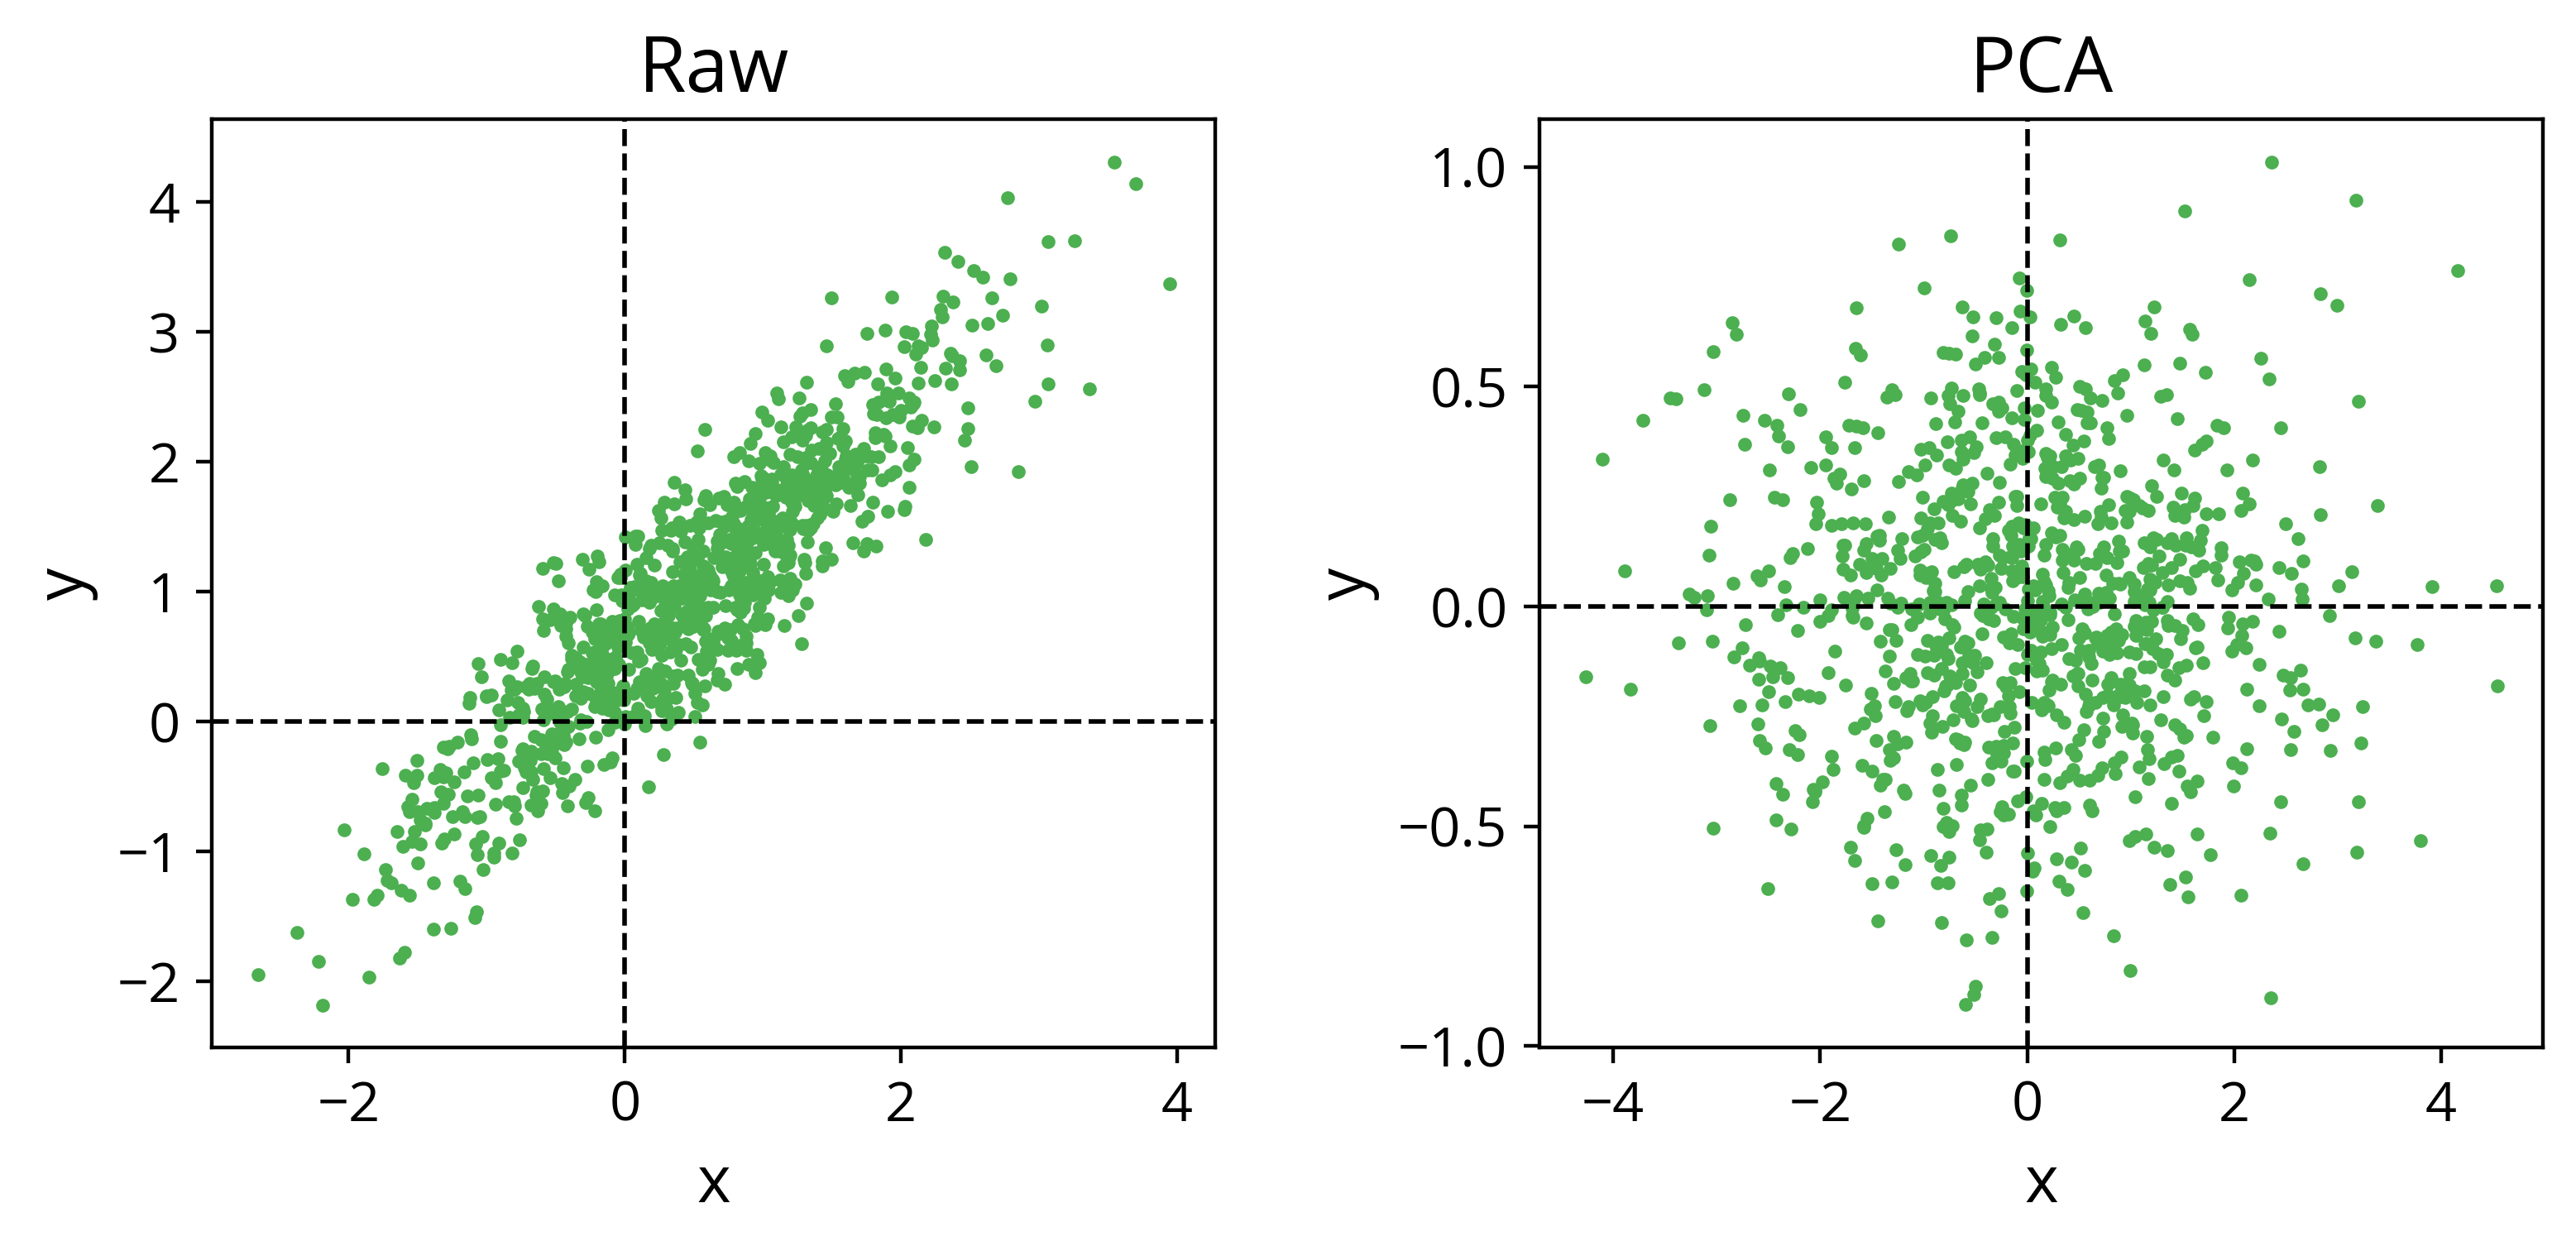

In [177]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

fig, axes = plt.subplots(ncols=2)
for ax, d, name in zip(axes, [data, data_pca], ["Raw", "PCA"]):
    ax.scatter(d[:, 0], d[:, 1])
    ax.axvline(0, c="k", lw=1, ls="--"), ax.axhline(0, c="k", lw=1, ls="--")
    ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_title(name)
fig.tight_layout()

We'll get into the details of what just happened in a tick, the takeaway here is that the PCA transformation has given us an x-axis which represents where the datapoint lies from bottom-left to top-right, and the y-axis is how far away from this bottom-left to top-right axis the data point is. We'll delve into this more soon, I promise!

# The background math

To explain what is happening mathematically when we ask `scikit-learn` to do a PCA transformation, we'll do it ourselves manually.

1. Get the covarariance of the dataset
2. Compute the eigenvectors and eigenvalues for the dataset.
3. Take the `N` largest eigenvalue/eigenvector pairs to reduce down to `N` dimensions
4. Use these `N` eigenvectors to construct a transformation matrix
5. Multiple this matrix onto your dataset to get a transformed output.

Before we jump into this, lets pause for a second to talk about eigenvectors and eigenvalues. [You can browse the wiki article on this if you want, but I also find wikipedia **super** dense when it comes to mathematical concepts](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors). At the simplest form, calculating the eigenvectors and values for our dataset is calculating a *linear* transformation. **More intuitively, if you imagine stretching a 2D image in a given direction, the eigenvector corresponds to the direction the image is stretched, and the eigenvalue corresponds to how much it was stretched.**

So in a way, what we're trying to do with PCA is to squish our "image" (dataset) along specific dimensions to get a result at the end that looks uniform (ie compare the raw data vs PCA transformed data above). Or moreso it's the opposite; determining the eigenvalues and eigenvectors for your dataset is determining how you could go from a unitary symmetric dataset (like a square image) and asking in what ways (and by how much) you should stretch this unitary dataset out so that it looks like your actual data.

A bit more formally, if you have a square matrix $A$, vector $v$ and scalar $\lambda$ such that

$$ Av = \lambda v, $$

then $v$ represents our eigenvector and $\lambda$ the eigenvalue of $A$. We can manually solve for these by solving the linear equations to give $\text{det}(A - \lambda I)$, where det is the determinant and $I$ the identity matrix. [For a good runthrough of the math, see this example](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors#Three-dimensional_matrix_example). For a 3D matrix $A$, this will give us a cubic equation with three roots (solutions) for $\lambda$ - our three eigenvalues.

Let's code this up real quick.

In [178]:
def manual_pca(data, n_components):
    # 1: Getting the mean and covariance
    mean, cov = np.mean(data, axis=0), np.cov(data.T)

    # 2: Compute eigenvectors and eigenvalues
    vals, vecs = np.linalg.eig(cov)

    # 3: Find the largest N eigenvalue indices
    s = np.argsort(vals)[::-1][:n_components] 
    # Sorts smallest to largest, so we reverse it and then grab the top

    # 4: Construct the transformation matrix
    eigenvals = vals[s]
    eigenvecs = vecs[:, s]

    # 5: Apply the transformation
    data_transformed = (data - mean) @ eigenvecs
    return data_transformed

data_transformed = manual_pca(data, 2)

Lets plot this and see how it turned out!

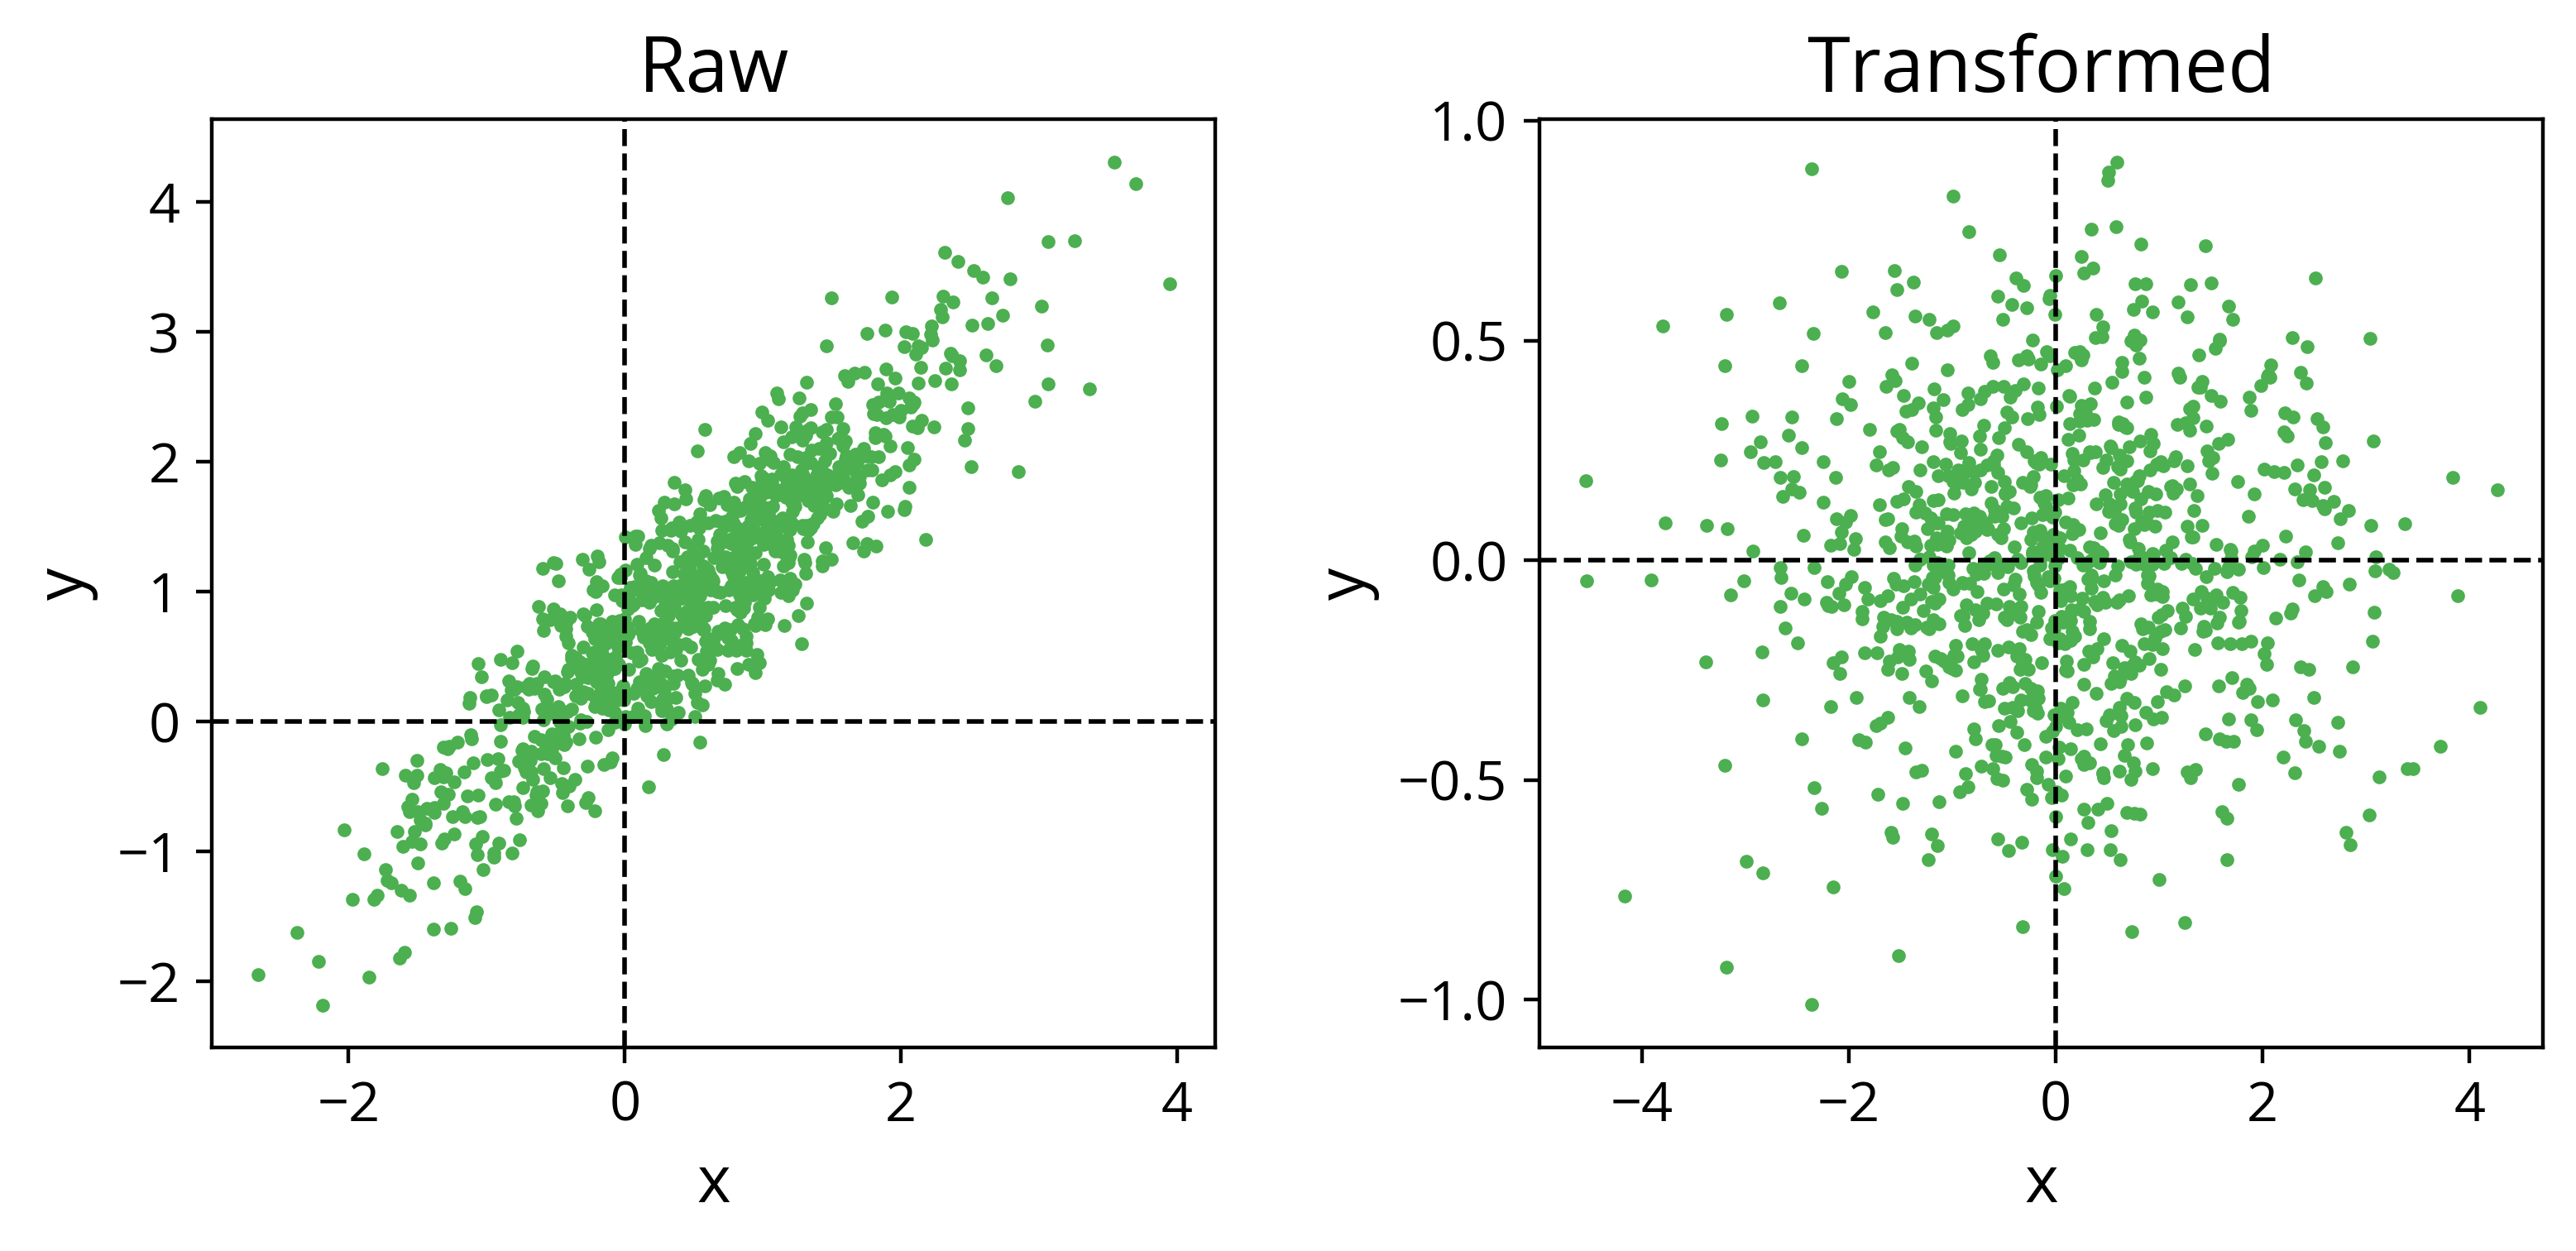

In [179]:
fig, axes = plt.subplots(ncols=2)
for ax, d, name in zip(axes, [data, data_transformed], ["Raw", "Transformed"]):
    ax.scatter(d[:, 0], d[:, 1])
    ax.axvline(0, c="k", lw=1, ls="--"), ax.axhline(0, c="k", lw=1, ls="--")
    ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_title(name)
fig.tight_layout()

You can see that this is effectively the same as the sklearn implementation!

# Getting the most out of sklearn

So far you've seen the `fit_transform` method, but we have at our hands [a lot more functionality](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). When we did the fit and transform manually, we had the eigenvectors and eigenvalues available. Sklearn has them under the hood as well:

In [180]:
# Behold, the eigenvectors!
eigenvecs = pca.components_
eigenvecs

array([[ 0.70557211,  0.70863813],
       [ 0.70863813, -0.70557211]])

In [181]:
# Behold, the eigenvalues!
eigenvals = pca.explained_variance_
eigenvals

array([1.94621132, 0.10024663])

In [182]:
# Behold, the mean values!
mean = pca.mean_
mean

array([0.46853279, 0.96342773])

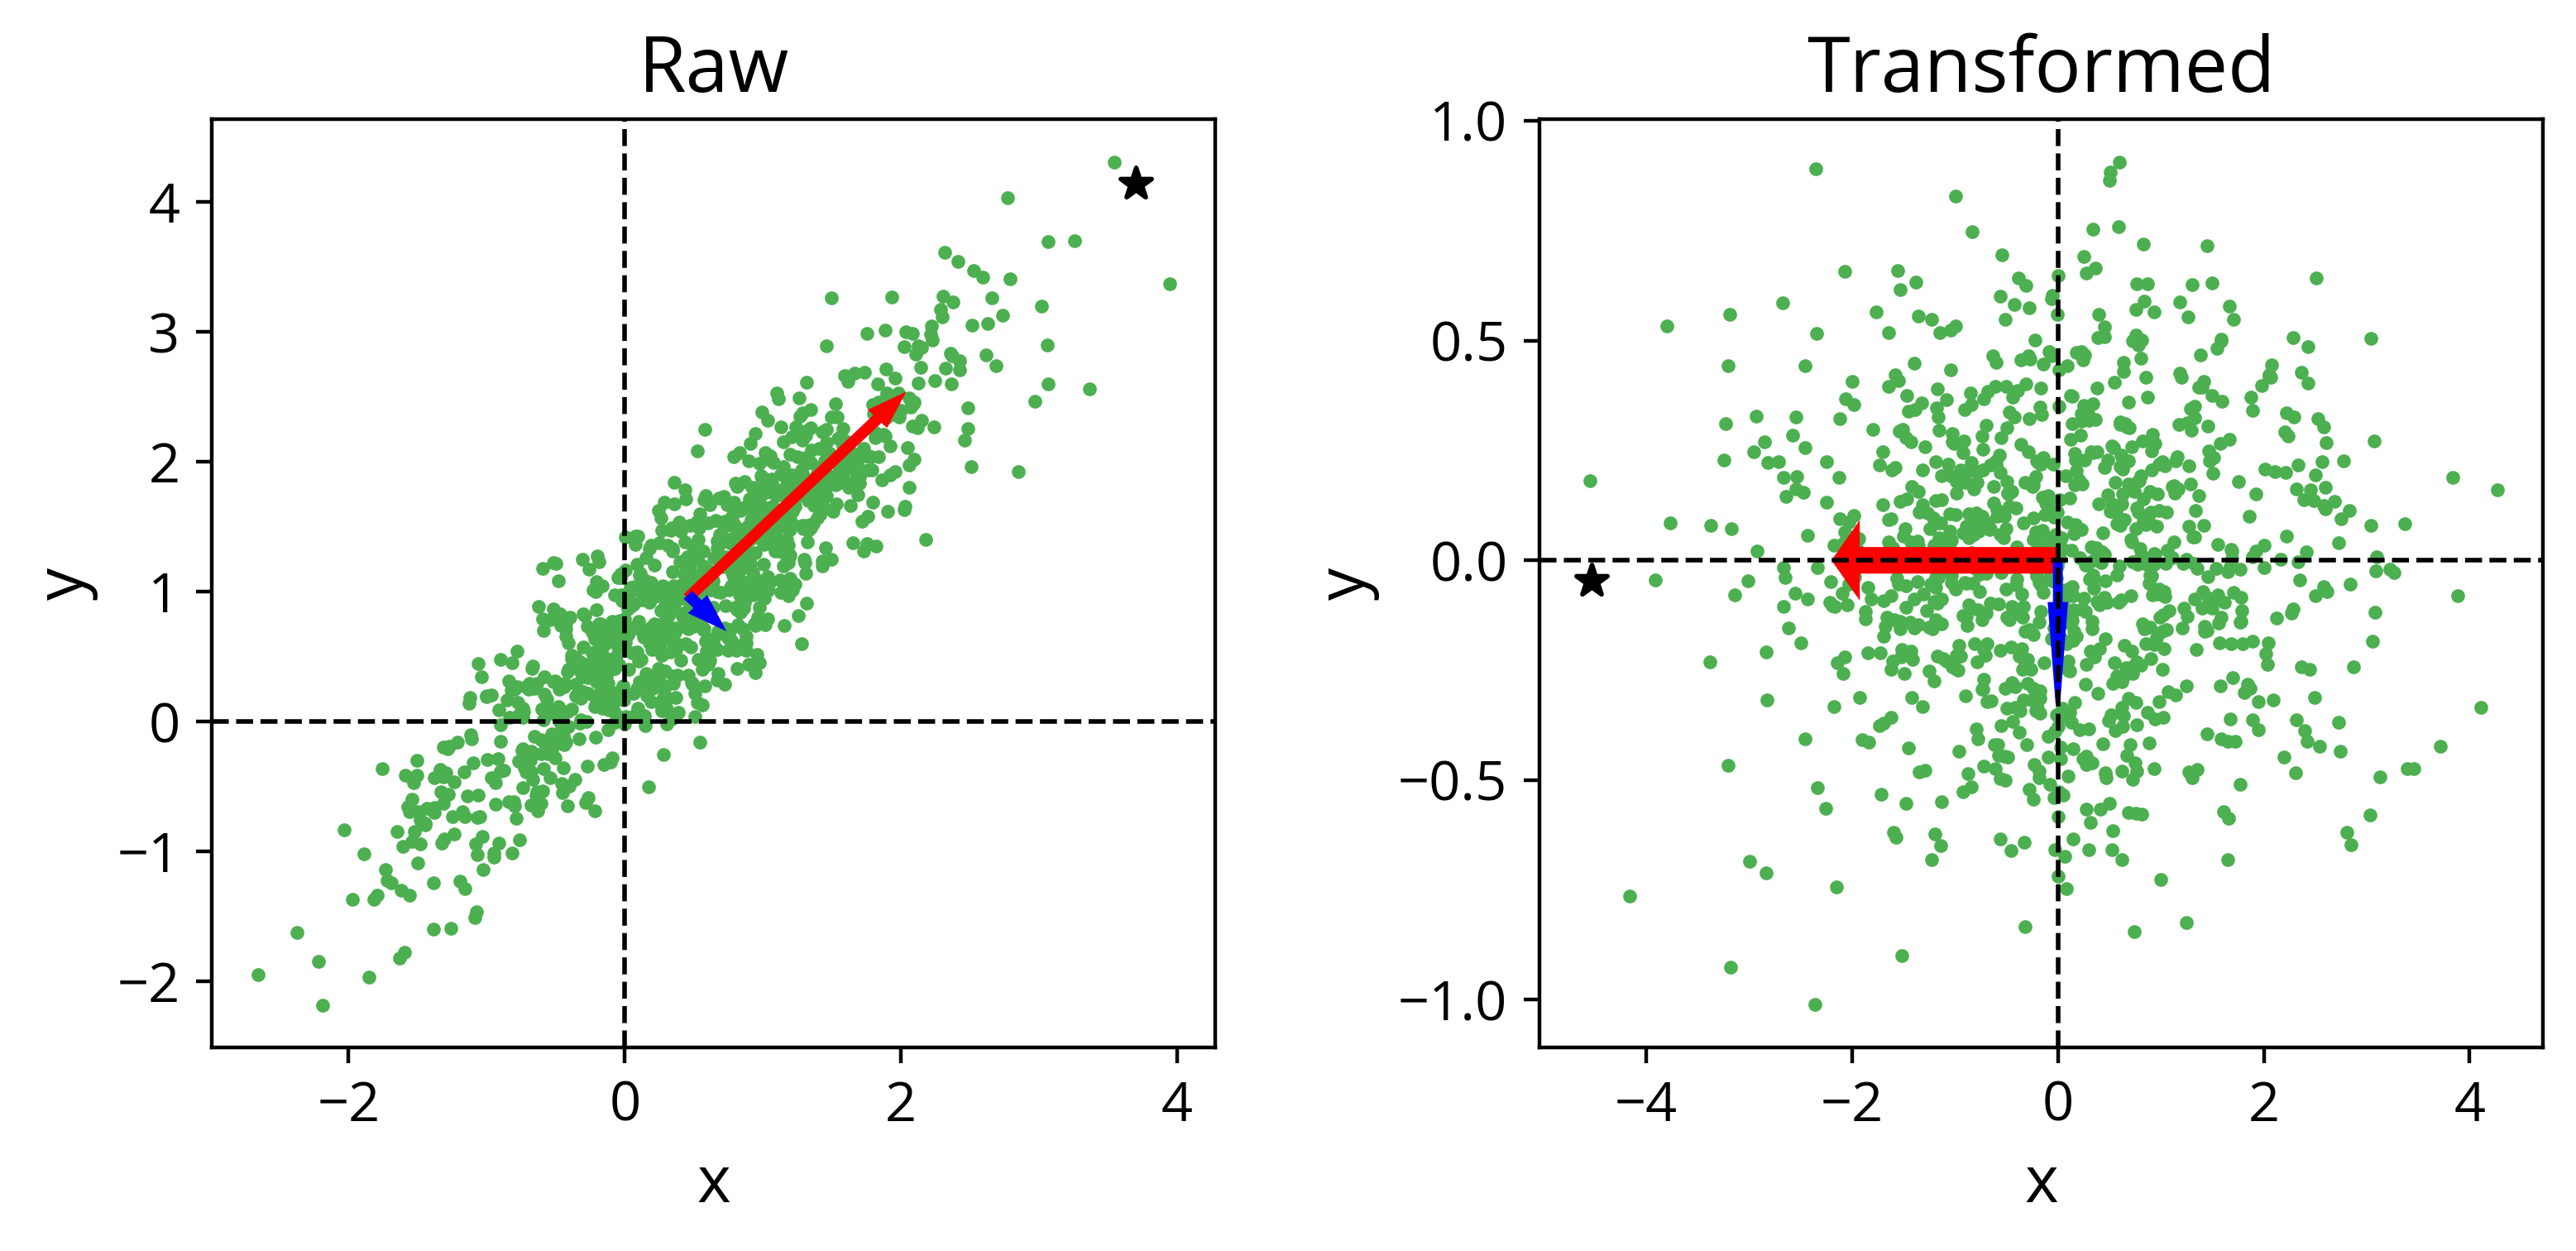

In [199]:
# Behold, plotting them together with the raw data!
fig, axes = plt.subplots(ncols=2)
for ax, d, name in zip(axes, [data, data_transformed], ["Raw", "Transformed"]):
    ax.scatter(d[:, 0], d[:, 1])
    ax.scatter(d[208, 0], d[208, 1], s=50, marker="*", c="k")
    ax.axvline(0, c="k", lw=1, ls="--"), ax.axhline(0, c="k", lw=1, ls="--")
    ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_title(name)
    if name == "Raw":
        ax.arrow(*mean, *(eigenvecs[:, 0] * eigenvals[0]), color="r", width=0.05)
        ax.arrow(*mean, *(eigenvecs[:, 1] * eigenvals[1]), color="b", width=0.05)
    else:
        ax.arrow(0, 0, -eigenvals[0], 0, color="r", width=0.05)
        ax.arrow(0, 0, 0, -eigenvals[1], color="b", width=0.05)
fig.tight_layout()

!!!main 

The largest eigenvector (scaled by its eigenvalue, as all eigenvectors are unit vectors) is shown in red, and the second vector is shown in blue. In the raw data, we center it on the dataset mean. On the right hand side, you can see how those two eigenvectors become the x and y axis. I've selected one point in the dataset (index 208) and plotted it using a black star, to provide a concrete example of how an individual point gets translated. You can see that the black star lies close to the red eigenvector axis in the raw data, and hence its y-value on the right is close to zero.

As a note, the eigenvalues are called "explained variance" because the size of the eigenvalue is is given by how much of the variance in your data can be "explained using" (exists along) that eigenvector. 

Another important thing to note here is that the eigenvalues are orthogonal to each other. This isn't a coincidence, its a central point to PCA and removing those correlations, but it might make you wonder if there are limits to PCA. What if your data isn't linearly seperable? Well, we can also do PCA using kernels which allow us to move beyond unit vectors. [See this API](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html) or [this example](https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html) for the details. 


You can also use the `PCA` object from sklearn to do inverse transformation, which is handy. If you use PCA and do some model fitting to find an optimal value or solution in the reduced dimensionality, you can translate your answer back to the original dimensions. You can use the `score` function to see how well a dataset fits your PCA. Under the hood, its calculating the probability the input new data, if it was drawn from a normal distribution configured using the mean and covariance calculated from your eigenvalues and eigenvalues.


# Summary 

PCA is a highly useful and efficient method of applying dimensional reduction to a dataset. Kernel based PCA methods allow for even more flexibility. 